# Decoded Quantum Interferometry Algorithm

In [1]:
import os, sys

# if this notebook is in notebooks/, go up one level then into src/
root = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
sys.path.insert(0, root)

import numpy as np
import warnings
import pprint
pp = pprint.PrettyPrinter(depth=4)

# Qiskit imports for simulation and circuit construction
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, partial_trace

# Custom module imports 
from dqi.initialization.state_preparation.gates import UnaryAmplitudeEncoding
from dqi.initialization.calculate_w import get_optimal_w

from dqi.dicke_state_preparation.gates import UnkGate

from dqi.decoding.gates import GJEGate
from dqi.decoding.usd import usd_reduction

from dqi.utils.graph import get_max_xorsat_matrix, find_graph_with_target_max_solutions
from dqi.utils.solver import brute_force_max
from dqi.utils.visualize import draw_graph, plot_results_union_plotly
from dqi.utils.counts import post_selection_counts, combine_counts

warnings.filterwarnings("ignore")

## Graph Generation and Max-XORSAT Problem

Set parameters for the graph and search, then generate a random graph.  
Solve the Max-XORSAT problem by exhaustively finding assignments that maximize the number of satisfied XOR constraints.

Found a graph after 1 iterations!
Max-XORSAT Constraint Matrix (B):
[[1 0 0 1 0 0]
 [1 0 0 0 1 0]
 [1 1 0 0 0 0]
 [0 1 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 1 0]
 [0 0 1 1 0 0]
 [0 0 1 0 0 1]
 [0 0 0 1 0 1]
 [0 0 0 0 1 1]]

Right-Hand Side Vector (v):
[1 1 1 1 1 1 1 1 1 1]

2 optimal assignments:
[0, 0, 0, 1, 1, 0]
[1, 1, 1, 0, 0, 1]


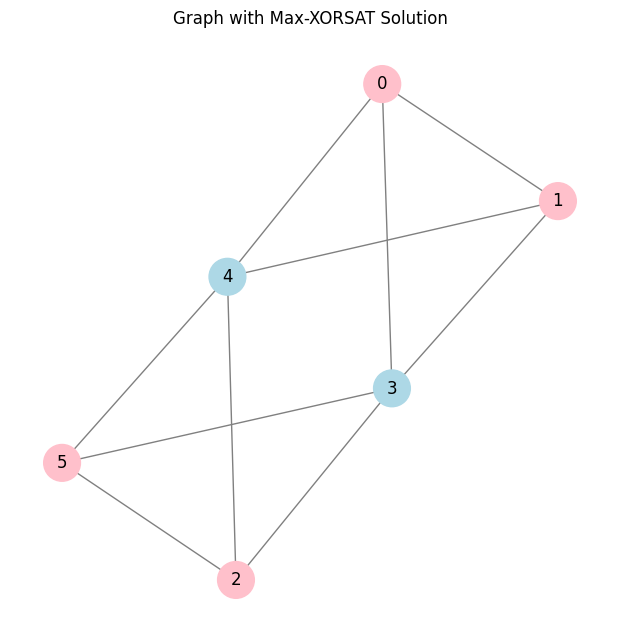

In [2]:
# Parameters for graph generation and search
num_nodes = 6              # Number of nodes (variables)
num_edges = 10             # Number of XOR constraints (edges)
target_max_solutions = 2   # Desired number of optimal assignments
max_iter = 1000            # Maximum search iterations
seed = 666            # Random seed for reproducibility

# Flag to decide if statevector plots should be shown (only for small problems)
show_sv = (num_nodes * num_edges < 50)

# Search for a graph with exactly the target number of max solutions
result = find_graph_with_target_max_solutions(
    num_nodes, num_edges, target_max_solutions, seed, max_iter
)
G, best_assignments, max_satisfied, iterations = result

if G is not None:
    assert best_assignments is not None, "Expected assignments when G is found"

    print(f"Found a graph after {iterations} iterations!")
    B, v = get_max_xorsat_matrix(G, v=None)
    print("Max-XORSAT Constraint Matrix (B):")
    print(B)
    print("\nRight-Hand Side Vector (v):")
    print(v)
    print(f"\n{len(best_assignments)} optimal assignments:")
    for assignment in best_assignments:
        print(list(assignment.values()))
    draw_graph(G, best_assignments[0])
else:
    print(f"No graph found in {max_iter} iterations …")


## Brute-Force Objective Landscape Visualization

Compute the brute-force objective values for every assignment and visualize the resulting landscape.
This plot will later be compared with the simulation data.


In [3]:
brute_force_results = brute_force_max(B, v)
plot_results_union_plotly(
    brute_force_results,
    {},
    plot_name="Objective Values Landscape",
    spline_smoothing=1.3
)


## Quantum Circuit Initialization and State Preparation

Prepare the quantum circuit components:

- **Weighted Unary Encoding:** Creates an initialization circuit based on optimal weights.
- **Dicke State Preparation:** Constructs a circuit to prepare a Dicke state used for error preparation.


In [4]:
n = len(B[0])  # Number of qubits corresponding to constraints
m, p, r, ell = len(B), 2, 1, 2  # Additional parameters for state preparation

# Compute optimal weight values for the initialization
w = get_optimal_w(m, ell, p, r)
print("Optimal W_k value: ", w.tolist())

Optimal W_k value:  [0.42257712736425834, 0.7071067811865475, 0.5669467095138411, 0.0]


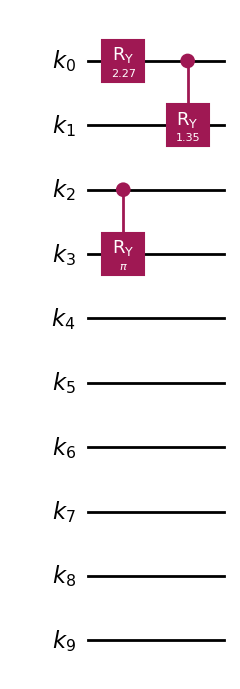

In [5]:
# Build the initialization circuit using Weighted Unary Encoding
init_qregs = QuantumRegister(m, name='k')
initialize_circuit = QuantumCircuit(init_qregs)
WUE_Gate = UnaryAmplitudeEncoding(num_bit=m, weights=w)
initialize_circuit.append(WUE_Gate, range(m))
display(initialize_circuit.decompose().draw('mpl'))

if show_sv:
    display(Statevector(initialize_circuit).draw('latex'))


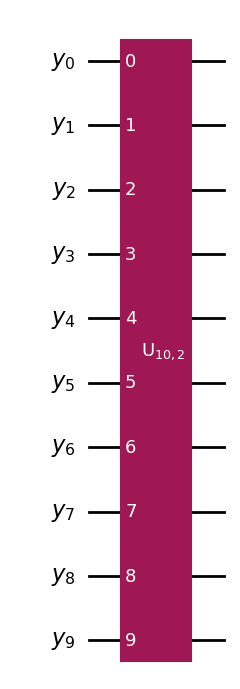

In [6]:
# Prepare the Dicke state circuit
dicke_qregs = QuantumRegister(m, name='y')
dicke_circuit = QuantumCircuit(dicke_qregs)
max_errors = int(np.nonzero(w)[0][-1]) if np.any(w) else 0
dicke_circuit.append(UnkGate(m, max_errors), range(m))
display(dicke_circuit.draw('mpl'))

## DQI Circuit Composition and Decoding

Build the DQI circuit by combining:

- The initialization and Dicke state circuits.
- Phase flip operations according to the right-hand side vector.
- Encoding of the constraint matrix via CNOT gates.

Then, construct the decoding circuit using the custom GJEGate.

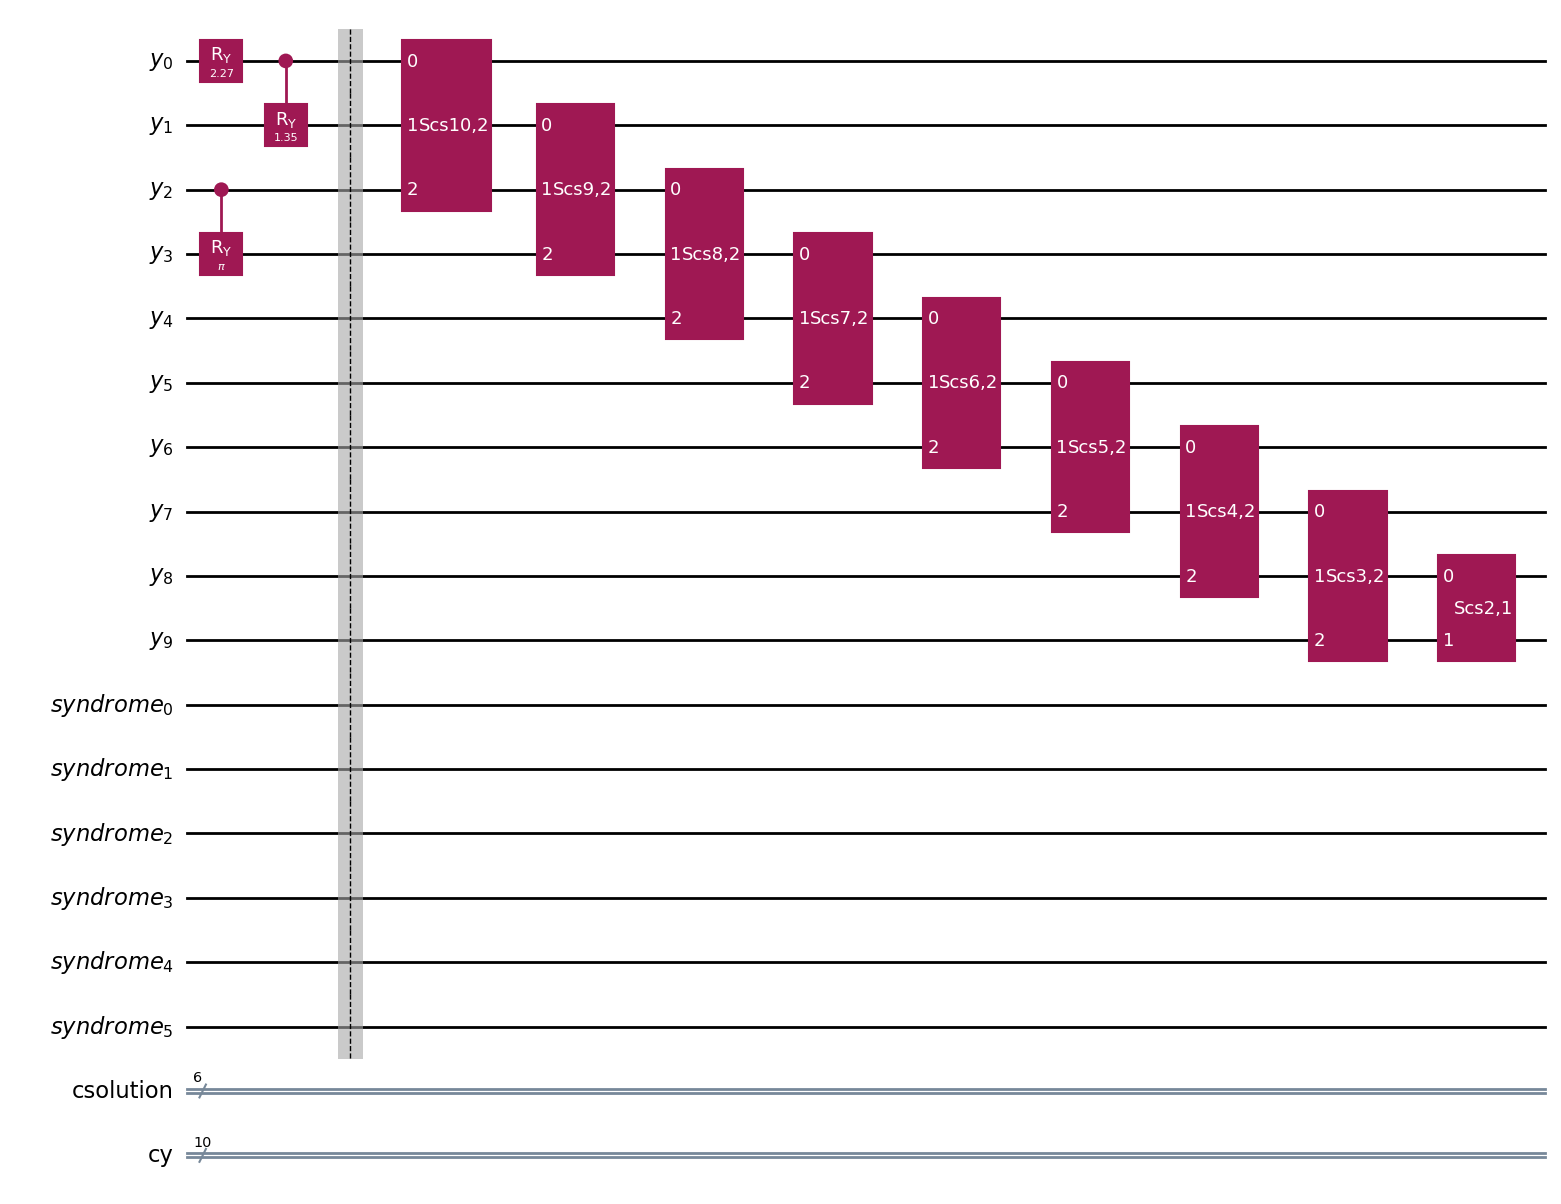

In [7]:
# Create registers for syndrome and measurement
dicke_qregs = QuantumRegister(m, name='y') 
dicke_cregs = ClassicalRegister(m, name='cy')
syndrome_qregs = QuantumRegister(n, name='syndrome')
syndrome_cregs = ClassicalRegister(syndrome_qregs.size, name='csolution')

# Build the DQI circuit by composing initialization and Dicke circuits
dqi_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs, syndrome_cregs, dicke_cregs)
dqi_circuit.compose(initialize_circuit, inplace=True)
dqi_circuit.barrier()
dqi_circuit.compose(dicke_circuit, inplace=True)
display(dqi_circuit.decompose().draw('mpl'))
if show_sv:
    display(Statevector(dqi_circuit).draw('latex'))

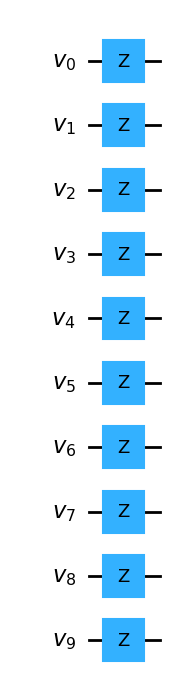

In [8]:
# Apply phase flip operations based on v
v_phase_qregs = QuantumRegister(m, name='v')
v_phase_flip_circuit = QuantumCircuit(v_phase_qregs)
for i in range(len(v)):
    if v[i] == 1:
        v_phase_flip_circuit.z(i)
display(v_phase_flip_circuit.draw('mpl'))

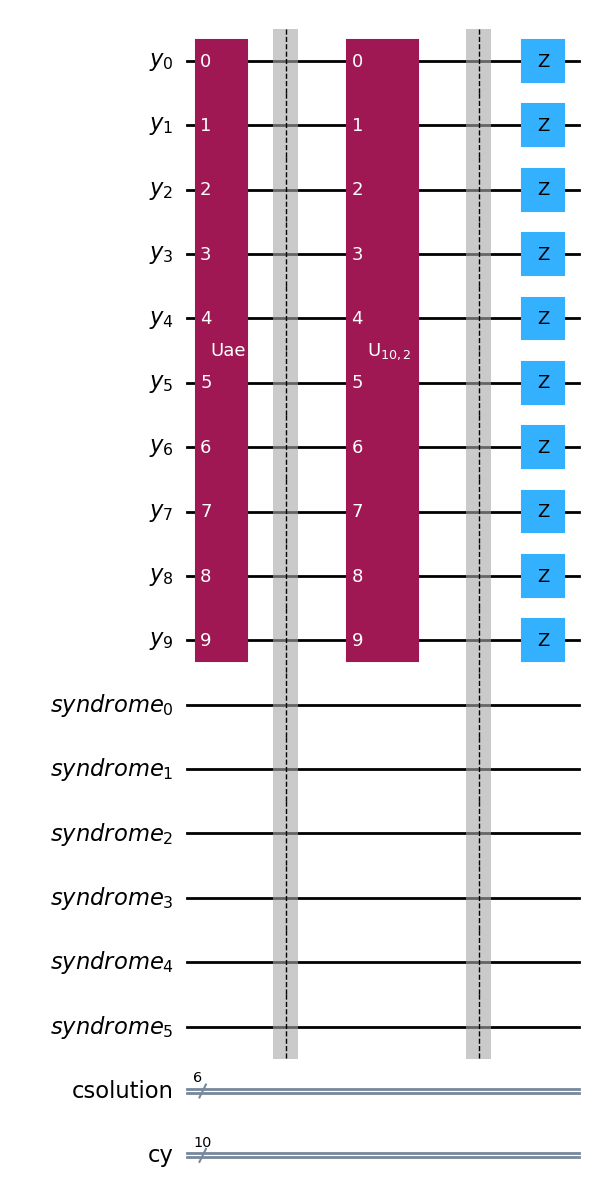

In [9]:
dqi_circuit.barrier()
dqi_circuit.compose(v_phase_flip_circuit, qubits=range(m), inplace=True)
display(dqi_circuit.draw('mpl'))

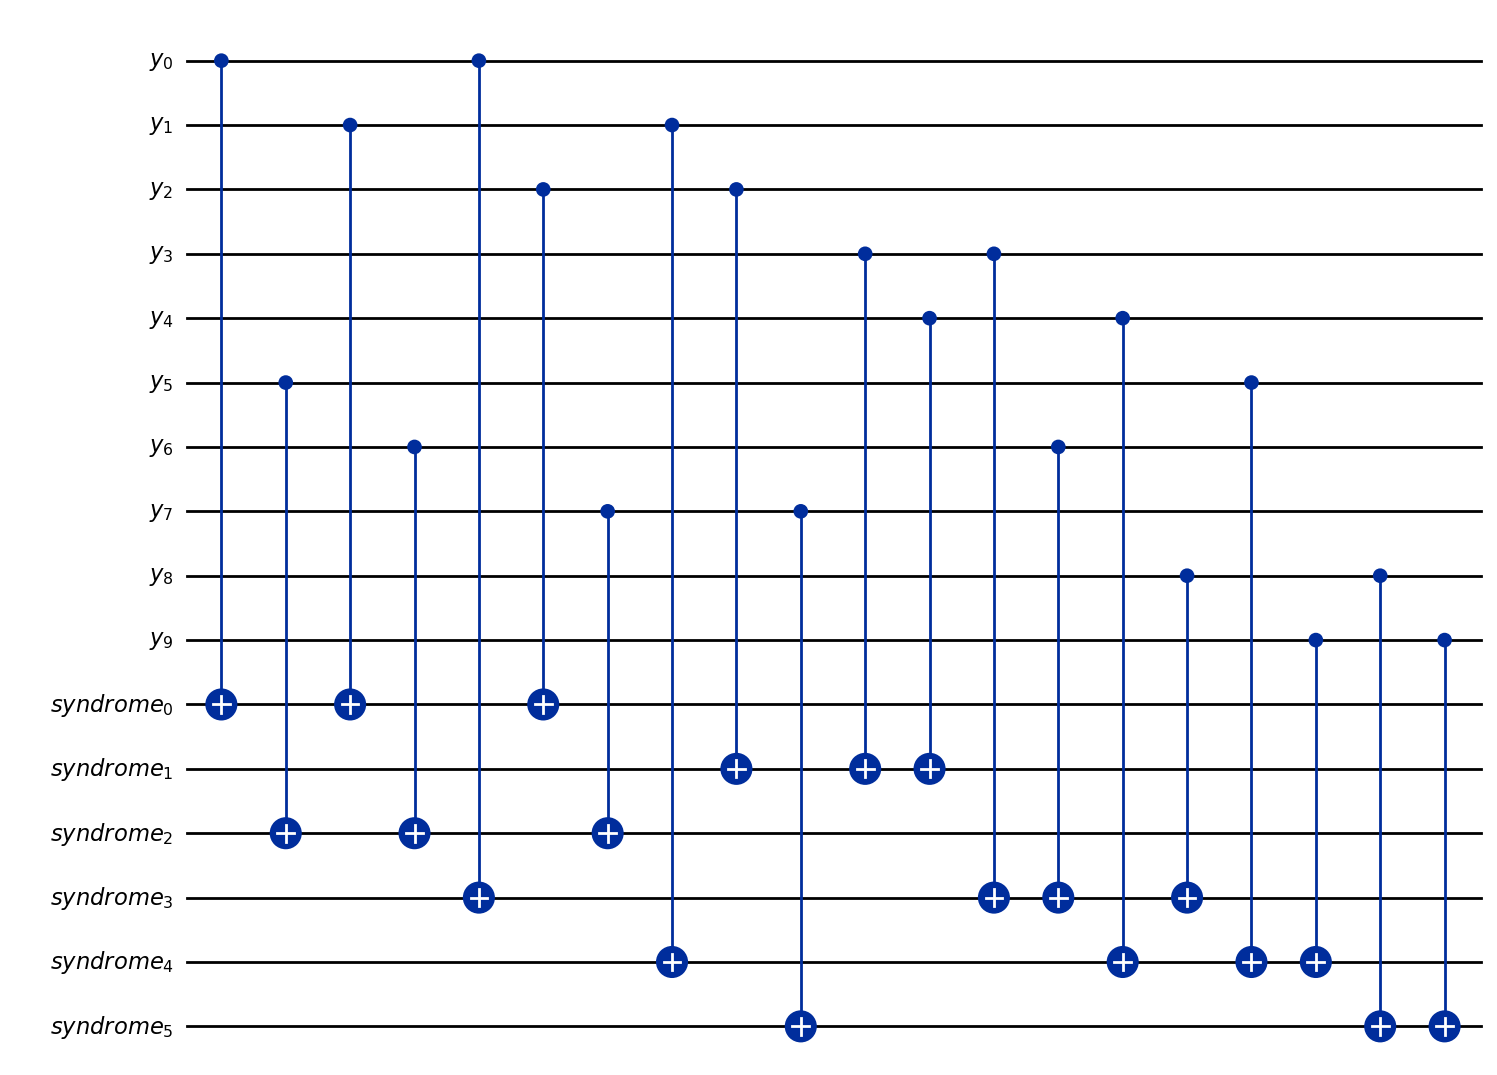

In [10]:
# Encode the constraint matrix B using CNOT gates
B_circuit = QuantumCircuit(dicke_qregs, syndrome_qregs)
for i in range(n):
    for j in range(m):
        if B.T[i][j] == 1:
            B_circuit.cx(j, m+i)
display(B_circuit.draw('mpl'))

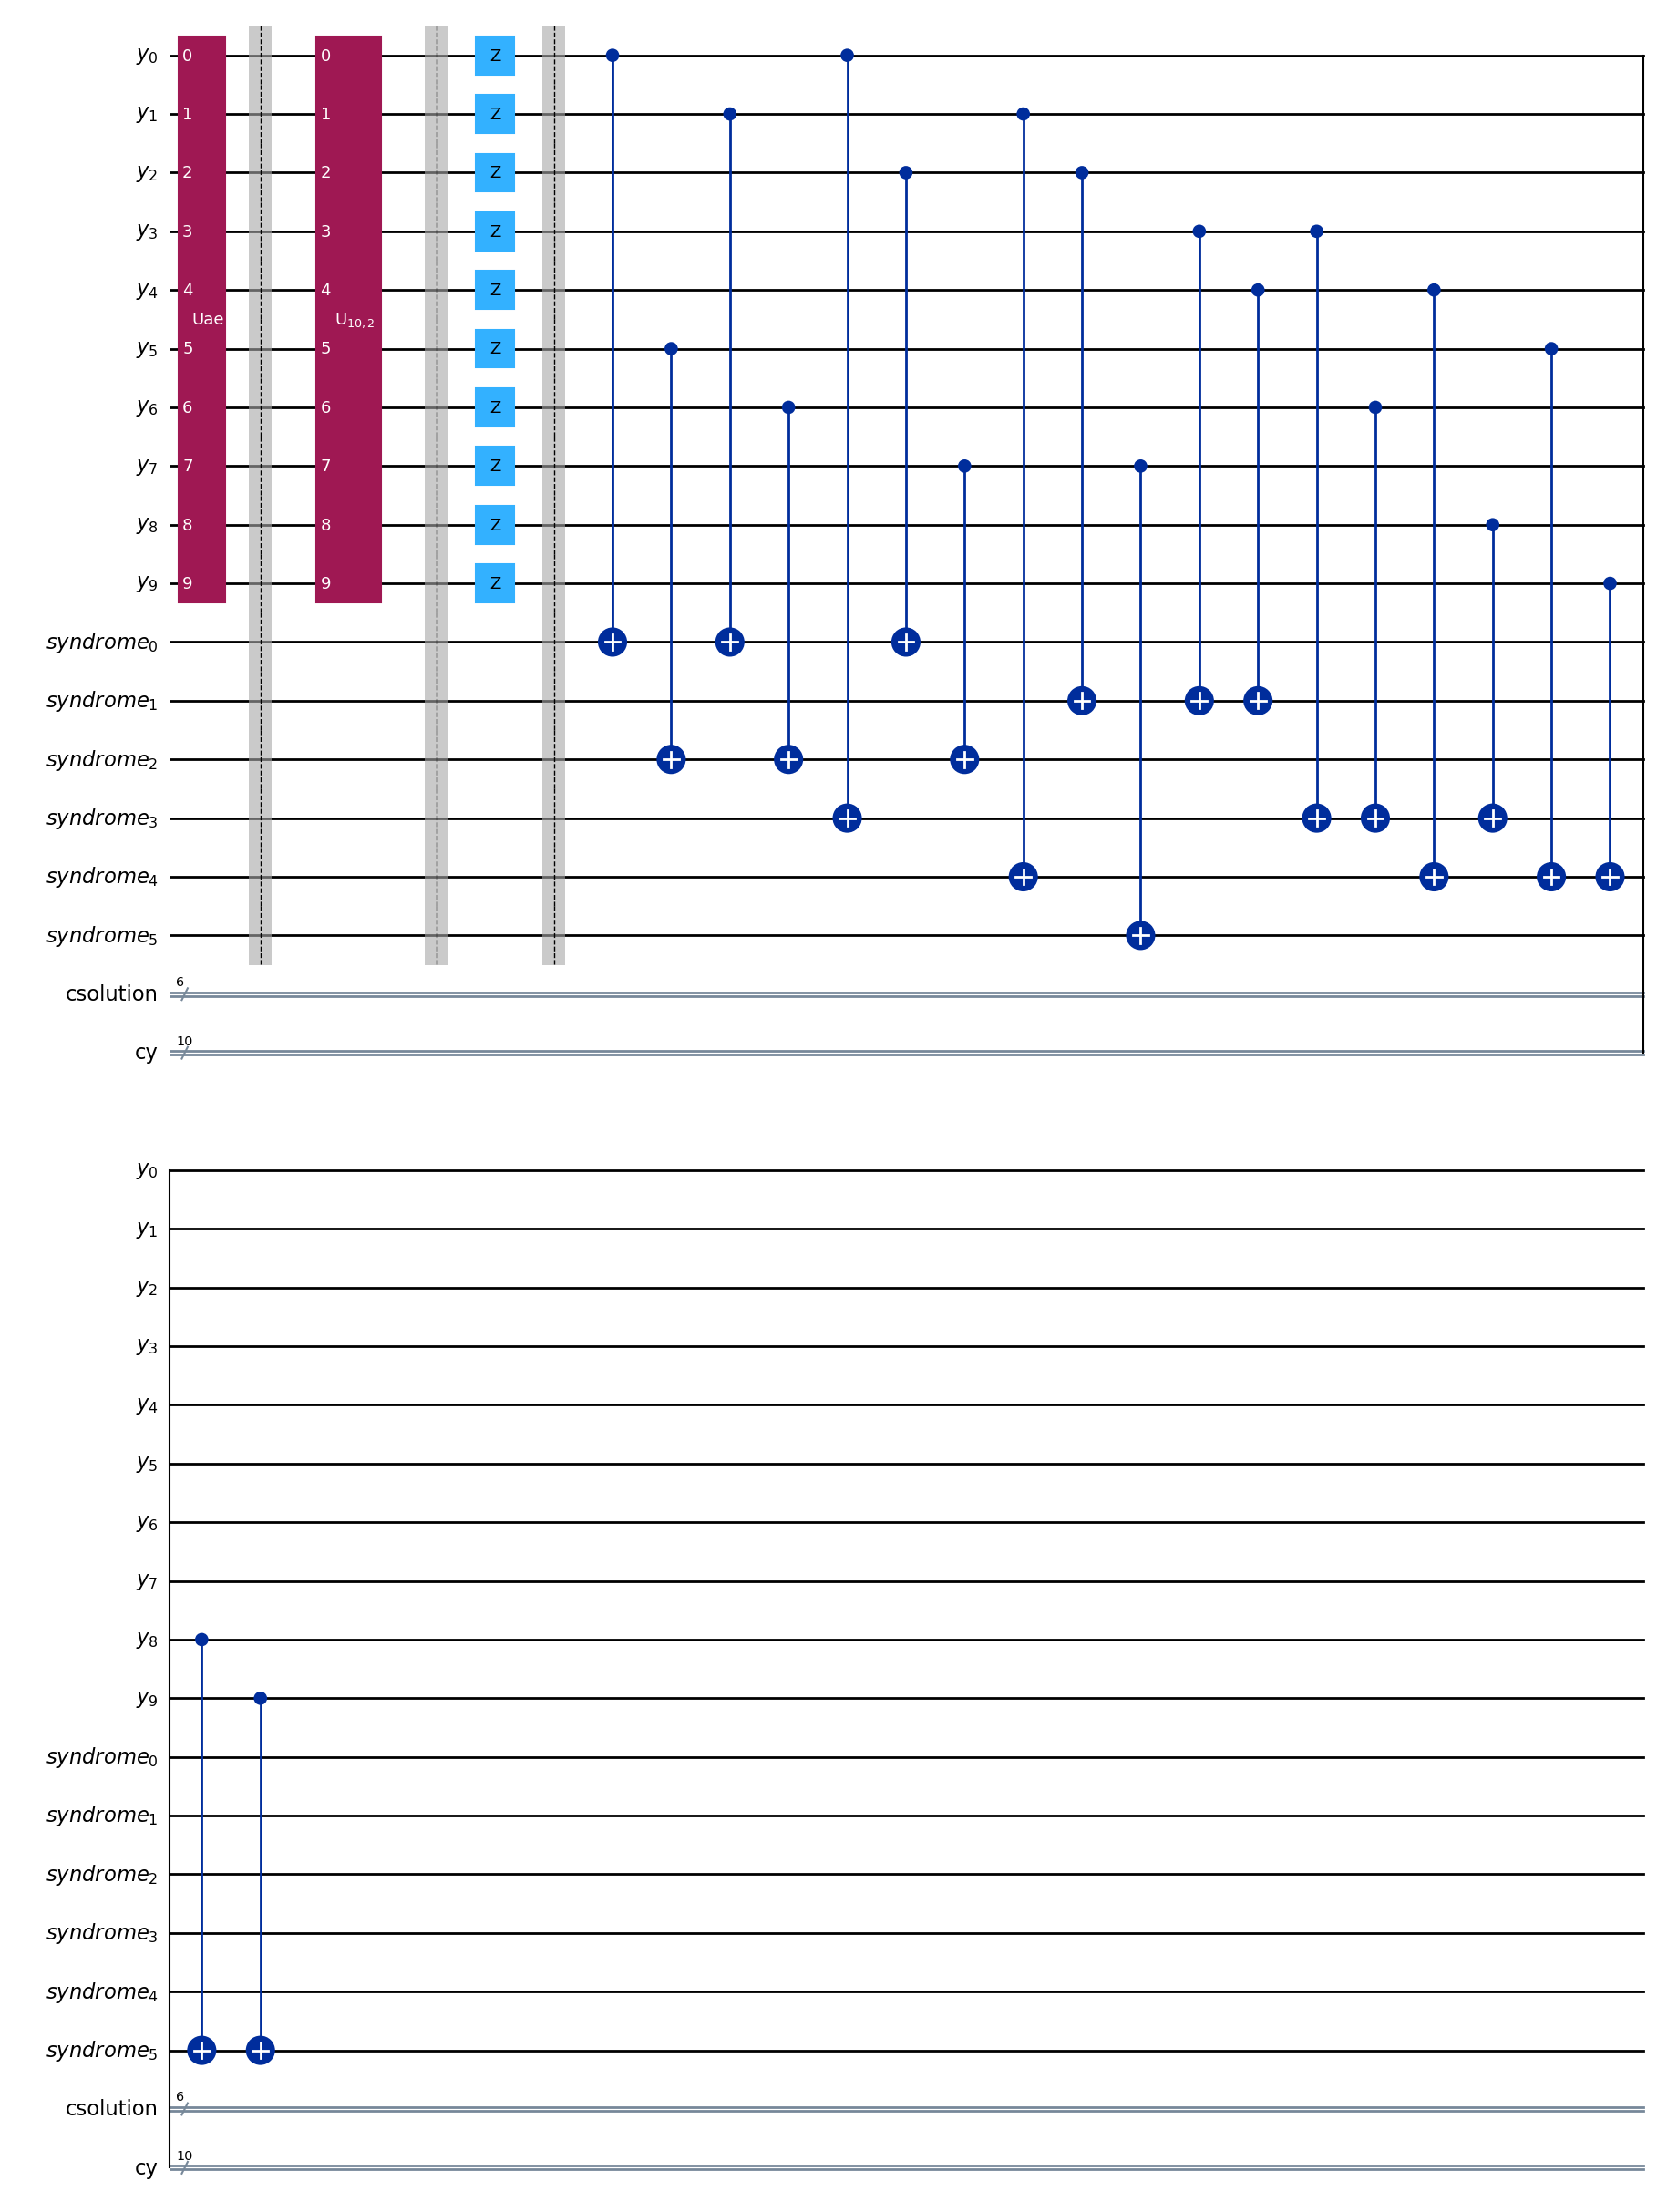

In [11]:
dqi_circuit.barrier()
dqi_circuit.compose(B_circuit, qubits=list(range(m+n)), inplace=True)
display(dqi_circuit.draw('mpl'))

# Visualize the reduced state (if desired)
if show_sv:
    reduced_density_matrix = partial_trace(Statevector(dqi_circuit), range(m))
    Statevector(np.diagonal(reduced_density_matrix)).draw('latex')



### Decoding Circuit Construction

Build the decoding circuit using the GJEGate. Depending on the sizes of the registers, the circuit
configuration varies. The decoding circuit is then appended (and its inverse is applied) to correct errors.

In [12]:
B_reduced = usd_reduction(dqi_circuit, B, wires=list(range(m)), max_attempts=100)
print("B shape        : ", B.shape)
print("B_reduced shape: ", B_reduced.shape)

B shape        :  (10, 6)
B_reduced shape:  (6, 6)


In [13]:
# B_reduced = B

In [14]:
B_reduced.shape

(6, 6)

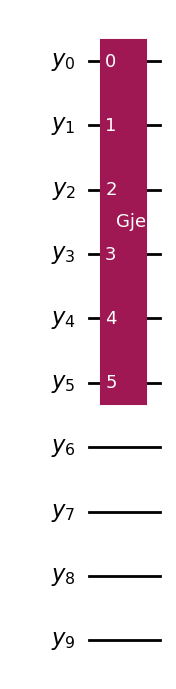

In [15]:
if n > m:
    decoding_circuit = QuantumCircuit(syndrome_qregs, name="GJE")
    GJE_gate = GJEGate(B_reduced.T)
    decoding_circuit.append(GJE_gate, range(n))
else:
    decoding_circuit = QuantumCircuit(dicke_qregs, name="GJE")
    GJE_gate = GJEGate(B_reduced.T)
    decoding_circuit.append(GJE_gate, range(n))

display(decoding_circuit.draw('mpl'))


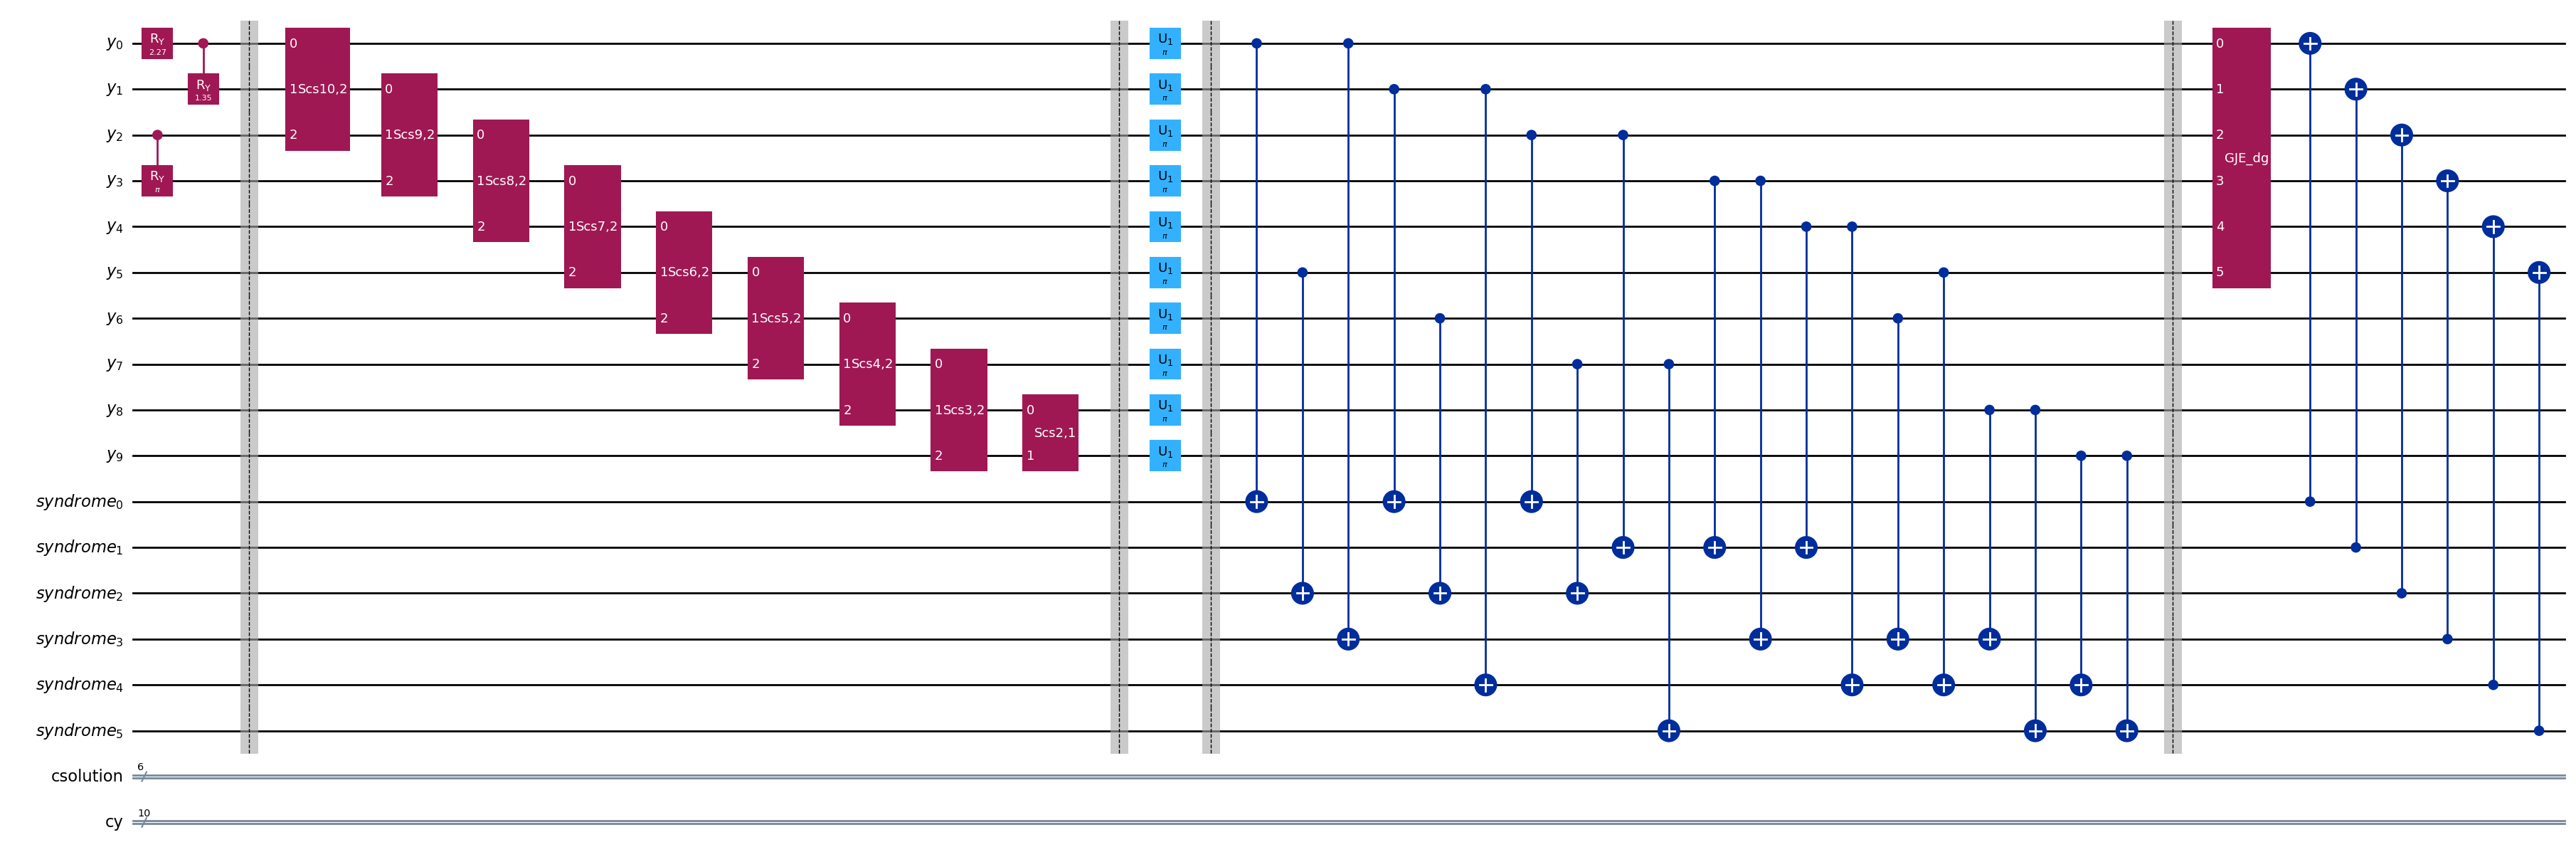

In [16]:
dqi_circuit_wo_decoder = dqi_circuit.copy()
dqi_circuit.barrier()

if n > m:
    dqi_circuit.append(decoding_circuit, range(m, m+n))
    for i in range(m):
        dqi_circuit.cx(syndrome_qregs[i], dicke_qregs[i])
    dqi_circuit.append(decoding_circuit.inverse(), range(m, m+n))
else:
    dqi_circuit.append(decoding_circuit.inverse(), range(m))
    for i in range(n):
        dqi_circuit.cx(syndrome_qregs[i], dicke_qregs[i])

display(dqi_circuit.decompose().draw('mpl', fold=-1))


if show_sv:
    reduced_density_matrix = partial_trace(Statevector(dqi_circuit), list(range(m, m+n)))
    display(Statevector(np.diagonal(reduced_density_matrix)).draw('latex'))

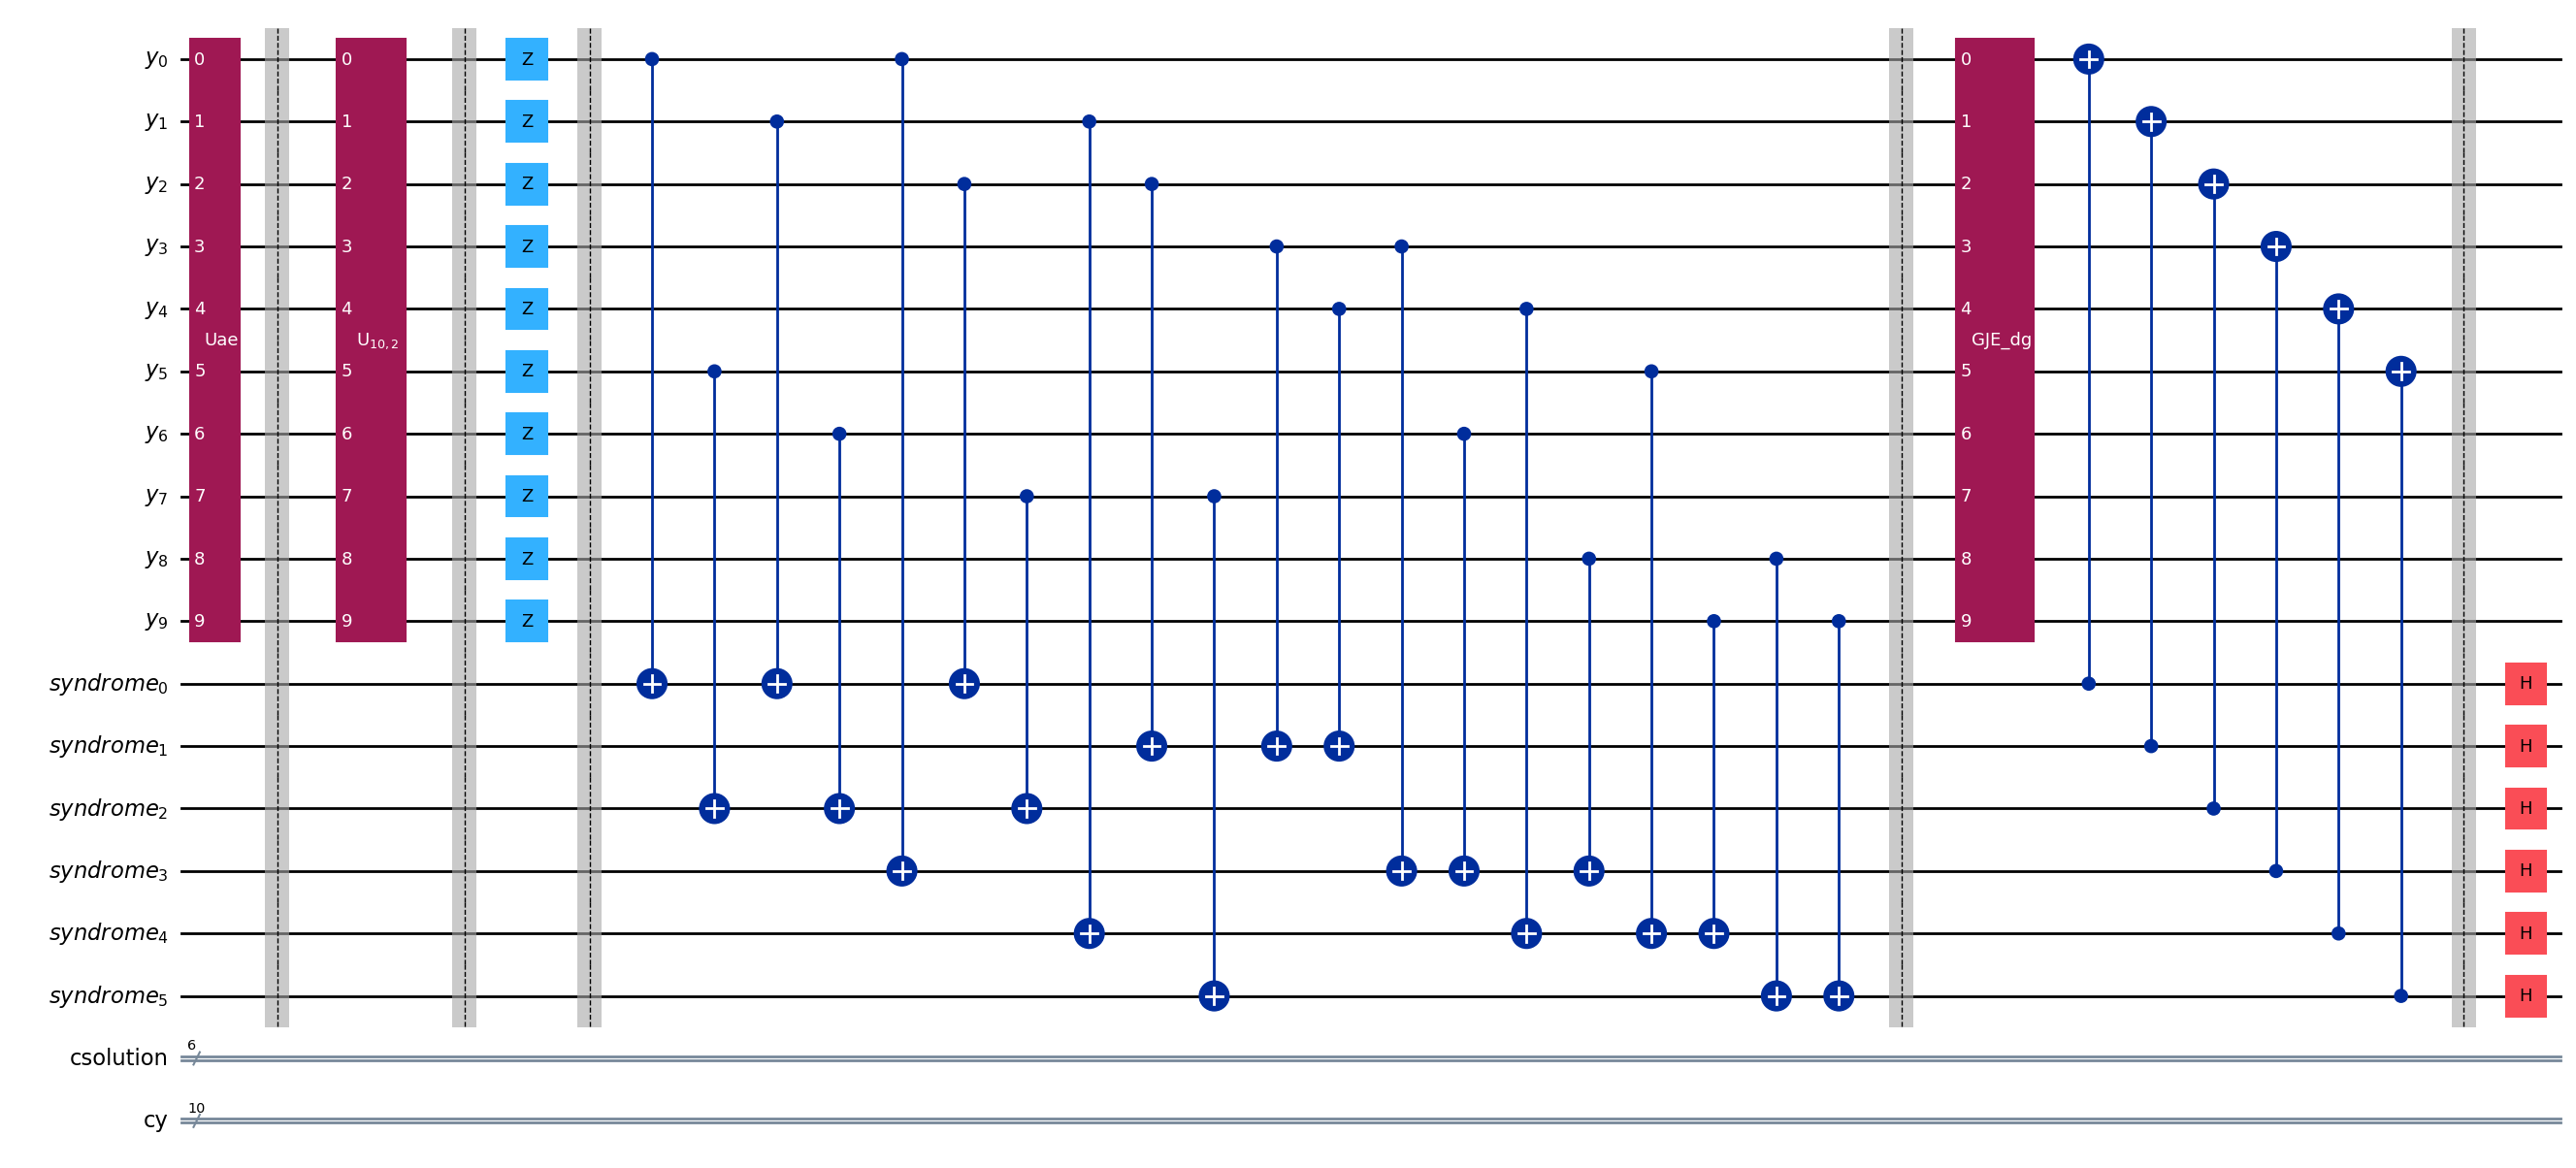

In [17]:
# Hadamard Transform
dqi_circuit.barrier()
for i in range(n):
    dqi_circuit.h(m+i)
display(dqi_circuit.draw('mpl', fold=-1))

if show_sv:
    reduced_density_matrix = partial_trace(Statevector(dqi_circuit), list(range(m, m+n)))
    display(Statevector(np.diagonal(reduced_density_matrix)).draw('latex'))

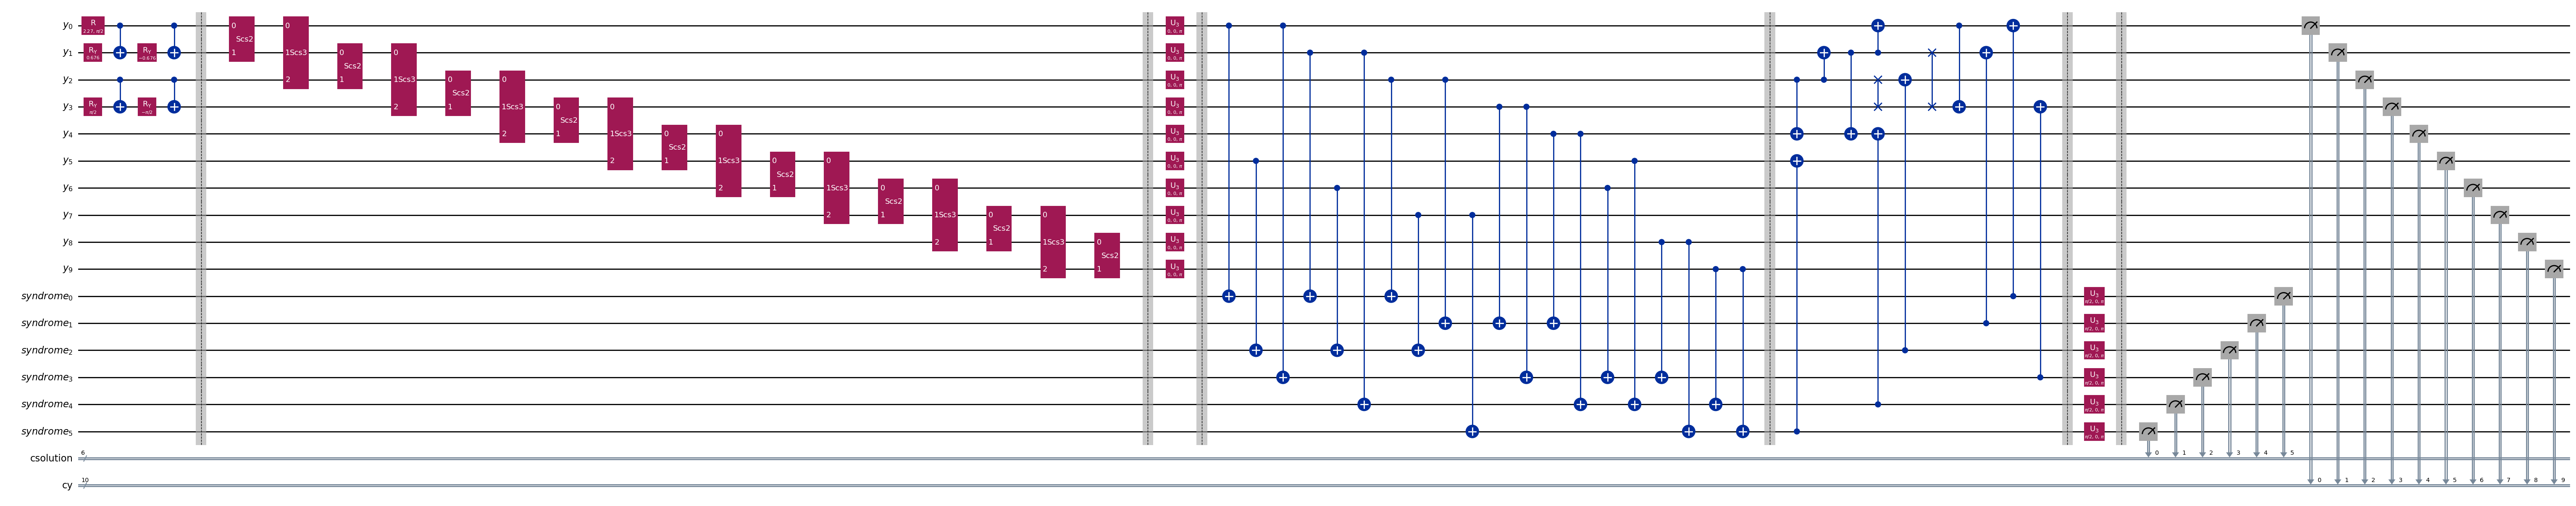

In [18]:
# Measurement
dqi_circuit.barrier()
dqi_circuit.measure(dicke_qregs, dicke_cregs)
dqi_circuit.measure(syndrome_qregs, syndrome_cregs[::-1])
display(dqi_circuit.decompose().decompose().draw('mpl', fold=-1))

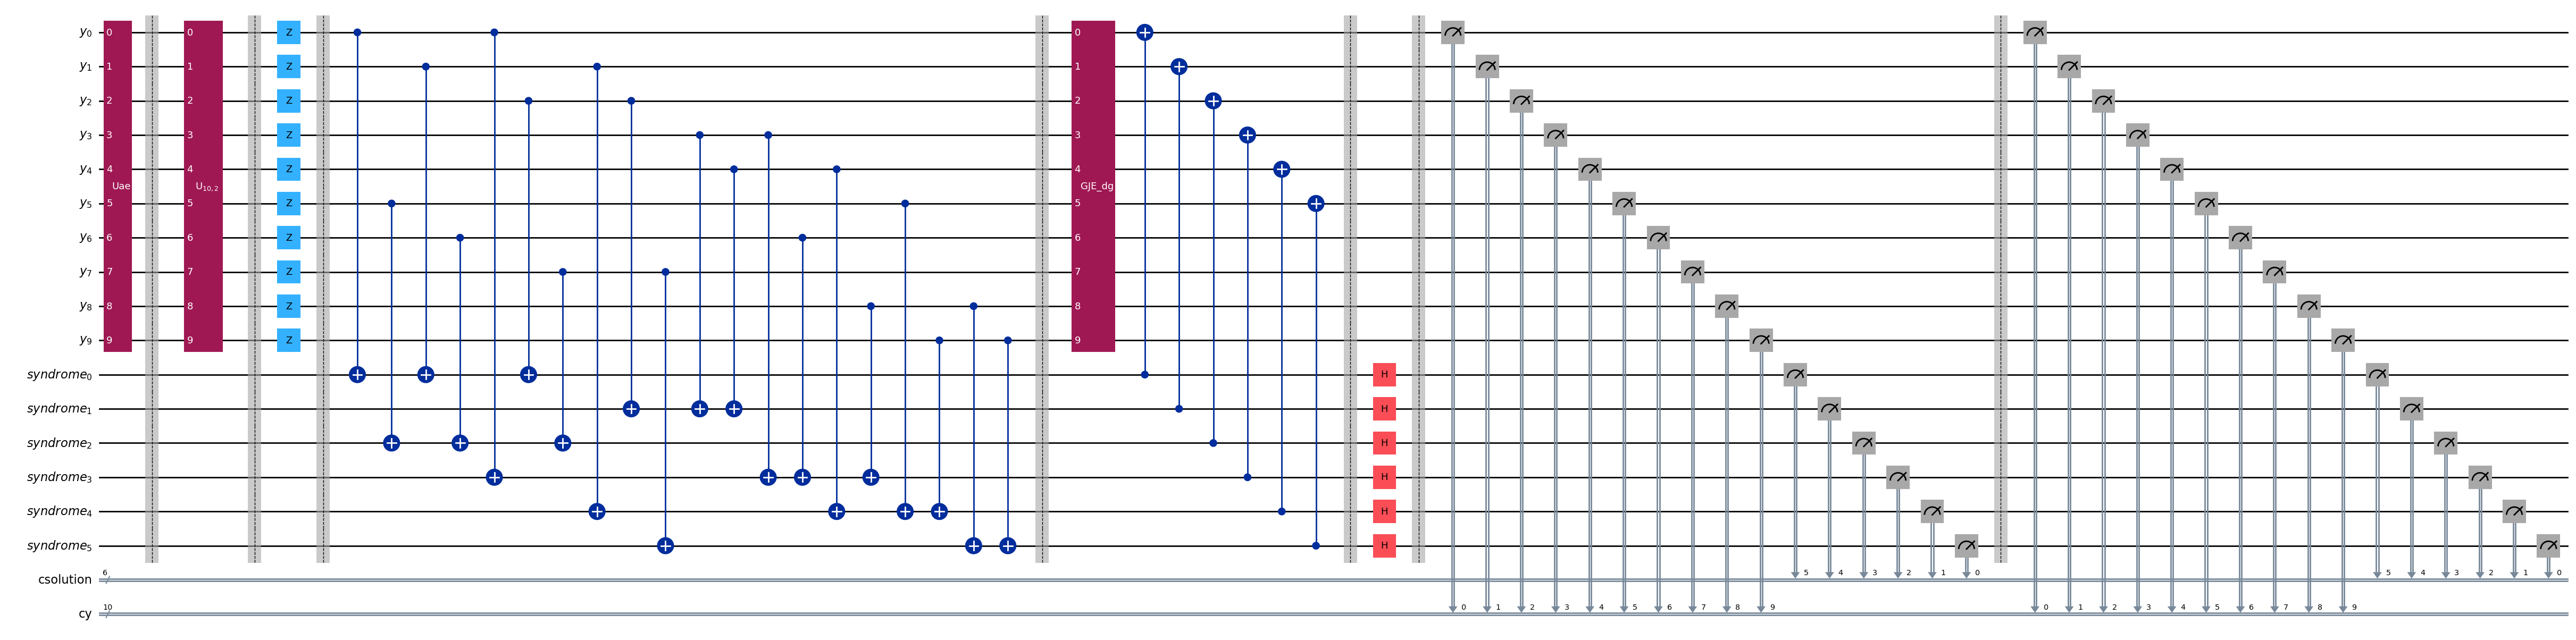

In [19]:
# Measurement
dqi_circuit.barrier()
dqi_circuit.measure(dicke_qregs, dicke_cregs)
dqi_circuit.measure(syndrome_qregs, syndrome_cregs[::-1])
display(dqi_circuit.draw('mpl', fold=-1))

## Simulation and Analysis

Run the DQI circuit on Qiskit's AerSimulator, then display and analyze the measurement counts.
Additionally, compare the brute-force objective landscape with the simulation results.

In [20]:
simulator = AerSimulator()
transpiled_circuit = transpile(dqi_circuit, backend=simulator)
result = simulator.run(transpiled_circuit, shots=100000).result()
counts = result.get_counts(dqi_circuit)
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
sorted_counts

{'0000000000 100000': 2890,
 '0000000000 100001': 2875,
 '0000000000 101001': 2874,
 '0000000000 010110': 2869,
 '0000000000 010111': 2865,
 '0000000000 011110': 2865,
 '0000000000 011111': 2812,
 '0000000000 101000': 2810,
 '0000000000 000110': 520,
 '0000000000 011100': 510,
 '0000000000 100101': 510,
 '0000000000 111001': 510,
 '0000000000 101011': 509,
 '0000000000 000111': 508,
 '0000000000 100010': 507,
 '0000000000 111000': 504,
 '0000000000 011101': 503,
 '0000000000 101101': 501,
 '0000000000 100100': 500,
 '0000000000 110000': 496,
 '0000000000 011011': 495,
 '0000000000 101100': 492,
 '0000000000 100011': 492,
 '0000000000 010010': 491,
 '0000000000 010011': 488,
 '0000000000 110001': 488,
 '0000000000 101010': 487,
 '0000000000 011010': 484,
 '0000000000 001111': 482,
 '0000000000 010100': 480,
 '0000000000 010101': 468,
 '0000000000 001110': 463,
 '0000001110 011111': 394,
 '0000110100 010111': 393,
 '1000110000 100001': 391,
 '0000000010 100001': 390,
 '0000000010 011110'

In [21]:
plot_results_union_plotly(
    brute_force_results,
    counts,
    plot_name="Comparison of DQI Result and True Objective Values",
    spline_smoothing=0.8
)


Further, filter and combine the counts, then visualize the modified data.

In [22]:
counts_filtered = post_selection_counts(counts)
plot_results_union_plotly(
    brute_force_results,
    counts_filtered,
    plot_name="Comparison of DQI Results with True Objective Values (Post-selected on |0⟩)",
    spline_smoothing=1.3
)


In [23]:
combined_counts = combine_counts(counts)
plot_results_union_plotly(
    brute_force_results,
    combined_counts,
    plot_name="Comparison of DQI Result and True Objective Values (Combined)",
    spline_smoothing=1.3
)


In [ ]:
breakthecodehere

## Lookup Table Syndrome Decoding Gate Construction

Generate all possible error patterns and corresponding syndromes, build a syndrome lookup table, and
construct a custom syndrome decoding gate using that lookup table.

In [ ]:
# Set the maximum number of errors as per ell
MAX_ERRORS = ell

# Generate error patterns: each row represents an error vector
errors = np.array([
    np.array([1 if i in ones_positions else 0 for i in range(n)])
    for num_ones in range(MAX_ERRORS + 1)
    for ones_positions in combinations(range(n), num_ones)
])[:, ::-1][:, :n]

if m > n:
    errors = np.pad(errors, ((0, 0), (0, m-n)), mode='constant', constant_values=0)

syndromes = (B.T @ errors.T % 2).T

print("Number of error patterns:", errors.shape[0])
print("Number of unique syndromes:", len(set(tuple(x) for x in list(syndromes))))
print("B shape:", B.shape)

syndrome_map = {
    "".join(map(str, synd)): "".join(map(str, err))
    for synd, err in zip(syndromes, errors)
}
print("Syndrome map:")
pp.pprint(syndrome_map)
print("Total entries in syndrome map:", len(syndrome_map))

Number of error patterns: 31
Number of unique syndromes: 16
B shape: (5, 5)
Syndrome map:
{'00000': '01111',
 '00011': '01100',
 '00101': '01101',
 '00110': '01110',
 '01001': '00111',
 '01010': '01011',
 '01100': '01010',
 '01111': '00110',
 '10001': '11100',
 '10010': '10000',
 '10100': '11110',
 '10111': '11101',
 '11000': '11011',
 '11011': '10111',
 '11101': '10110',
 '11110': '11010'}
Total entries in syndrome map: 16


Define a function to create a custom syndrome decoding gate based on the lookup table.

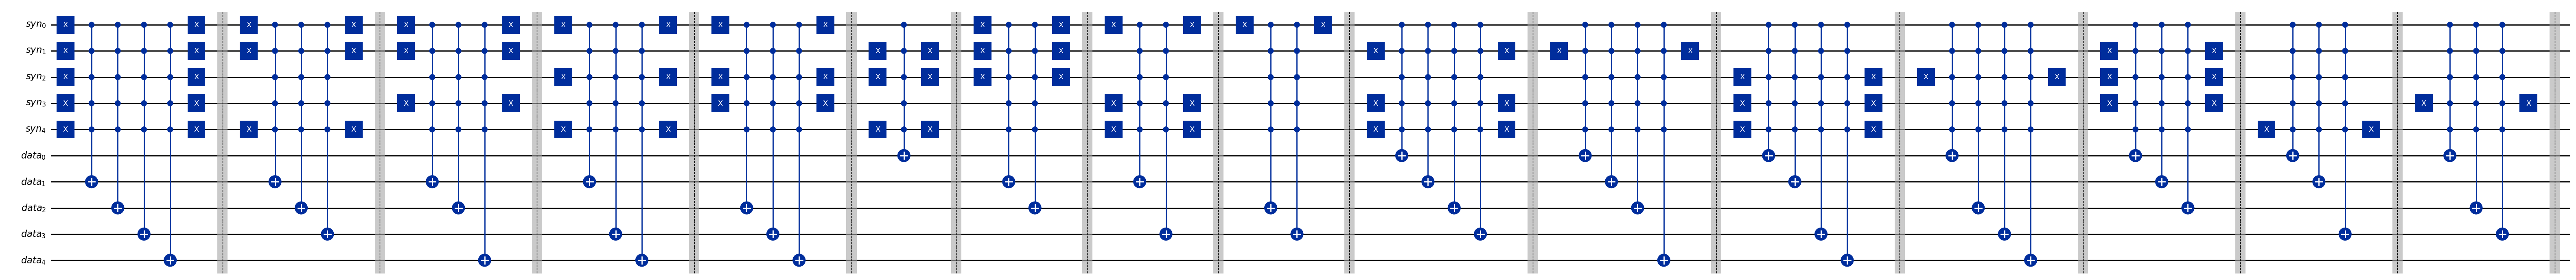

In [ ]:
def syndrome_decode_lookuptable_gate(syndrome_map: dict) -> QuantumCircuit:
    """
    Create a custom Qiskit gate for syndrome decoding using a lookup table.
    
    Args:
        syndrome_map: A dictionary mapping syndrome bit-string patterns to error correction patterns.
    
    Returns:
        A QuantumCircuit implementing the syndrome decoding.
    """
    # Determine register sizes from the lookup table
    first_key = next(iter(syndrome_map.keys()))
    n_syndrome = len(first_key) if isinstance(first_key, str) else first_key.bit_length()
    first_val = next(iter(syndrome_map.values()))
    n_data = len(first_val) if isinstance(first_val, str) else first_val.bit_length()

    syndrome_reg = QuantumRegister(n_syndrome, name='syn')
    data_reg = QuantumRegister(n_data, name='data')
    circuit = QuantumCircuit(syndrome_reg, data_reg, name="syndrome_decode")

    # Process each syndrome pattern and apply the corresponding corrections
    for syndrome_pattern, error_pattern in syndrome_map.items():
        syndrome_bits = syndrome_pattern.zfill(n_syndrome) if isinstance(syndrome_pattern, str) else format(syndrome_pattern, f'0{n_syndrome}b')
        error_bits = error_pattern.zfill(n_data) if isinstance(error_pattern, str) else format(error_pattern, f'0{n_data}b')

        inverted_controls = []
        controls = []
        for idx, bit in enumerate(syndrome_bits):
            if bit == '0':
                circuit.x(syndrome_reg[idx])
                inverted_controls.append(idx)
            controls.append(syndrome_reg[idx])
        # Apply corrections: if error bit is '1', flip the corresponding data qubit
        for data_idx, bit in enumerate(error_bits):
            if bit == '1':
                if len(controls) == 1:
                    circuit.cx(controls[0], data_reg[data_idx])
                else:
                    circuit.mcx(controls, data_reg[data_idx])
        # Undo the inversions on the syndrome register
        for idx in inverted_controls:
            circuit.x(syndrome_reg[idx])
        circuit.barrier()
    
    return circuit

# Create and visualize the syndrome decoding gate
lookuptable_gate = syndrome_decode_lookuptable_gate(syndrome_map)
display(lookuptable_gate.draw('mpl', fold=-1))

## Simulation

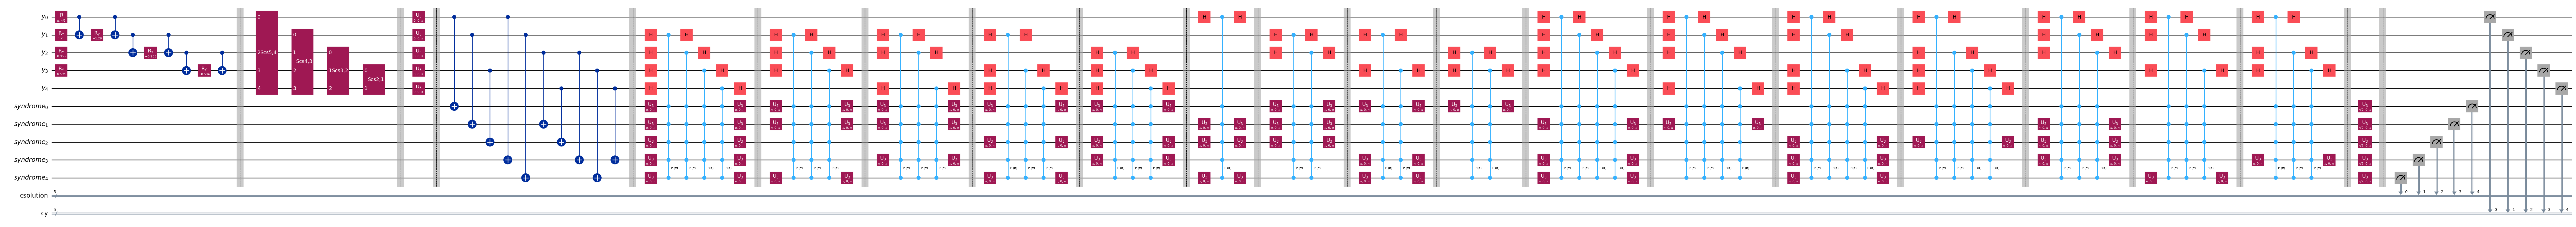

In [ ]:
dqi_lookuptable = dqi_circuit_wo_decoder.copy()
dqi_lookuptable.barrier()

# Append the syndrome decoding gate to the appropriate qubits (data and syndrome registers)
dqi_lookuptable.append(lookuptable_gate, list(range(m, m+n)) + list(range(m)))

# Apply Hadamard gates to syndrome qubits for basis change
for i in range(syndrome_qregs.size):
    dqi_lookuptable.h(dicke_qregs.size + i)
dqi_lookuptable.barrier()
dqi_lookuptable.measure(dicke_qregs, dicke_cregs)
dqi_lookuptable.measure(syndrome_qregs, syndrome_cregs[::-1])
display(dqi_lookuptable.decompose().decompose().draw('mpl', fold=-1))

In [ ]:
simulator = AerSimulator()
transpiled_circuit = transpile(dqi_lookuptable, backend=simulator)
result = simulator.run(transpiled_circuit, shots=100000).result()
counts = result.get_counts(dqi_lookuptable)
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
sorted_counts

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 13.94773 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ElidePermutations - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMeasure - 0.95344 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveIdentityEquivalent - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutativeCancellation - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 3.93391 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Split2QUnitaries - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 4.04453 (ms)
INFO:qis

{'00000 11100': 29513,
 '00000 00011': 29263,
 '11110 11100': 17240,
 '11110 00011': 17189,
 '11110 01110': 481,
 '11110 00111': 479,
 '11110 11000': 466,
 '11110 01011': 465,
 '11110 10001': 459,
 '11110 01010': 457,
 '11110 00110': 448,
 '11110 11101': 442,
 '11110 10100': 441,
 '11110 10101': 439,
 '11110 11001': 439,
 '11110 00010': 421,
 '11110 10011': 296,
 '11110 01100': 273,
 '00000 10000': 61,
 '00000 01111': 59,
 '11110 11111': 50,
 '11110 00000': 46,
 '00000 10111': 36,
 '00000 10010': 35,
 '00000 00100': 34,
 '00000 11010': 34,
 '00000 01001': 33,
 '00000 00001': 33,
 '00000 10110': 33,
 '00000 11110': 30,
 '00000 00101': 28,
 '00000 11011': 28,
 '00000 01101': 26,
 '00000 01000': 25,
 '00000 00010': 16,
 '00000 10101': 13,
 '00000 01110': 12,
 '00000 10100': 12,
 '00000 01010': 12,
 '00000 00110': 12,
 '00000 11001': 12,
 '00000 11111': 10,
 '00000 11000': 9,
 '00000 10001': 8,
 '11110 01111': 8,
 '00000 00000': 8,
 '00000 00111': 7,
 '00000 01011': 7,
 '00000 11101': 7,
 

In [ ]:
brute_force_results = brute_force_max(B, v, first_part="0"*m)
external_data = counts
plot_results_union_plotly(
    brute_force_results,
    external_data,
    plot_name="Comparison of DQI Result and True Objective Values (Lookup Table)",
    spline_smoothing=0.8
)

In [ ]:
external_data_filtered = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)
                          if sum([int(x) for x in k.split(" ")[0]]) == 0}
brute_force_results = brute_force_max(B, v, first_part="0"*m)
plot_results_union_plotly(
    brute_force_results,
    external_data_filtered,
    plot_name="Comparison of DQI Result and True Objective Values (Post-selected on |0⟩, Lookup Table)",
    spline_smoothing=1.3
)


In [ ]:
combined_counts = combine_counts(counts)
brute_force_results = brute_force_max(B, v, first_part="")
plot_results_union_plotly(
    brute_force_results,
    combined_counts,
    plot_name="Comparison of DQI Result and True Objective Values (Combined, Lookup Table)",
    spline_smoothing=1.3
)